<h2><center>Programa Nanodegree Engenheiro de Machine Learning</center></h2>
<h3><center>Relatório do projeto de conclusão de machine learning - Capstone</center></h3>
<br>
<center>  
Robson Azevedo Rung<br>
    <i>01/08/2019</i>
</center> 

### Visão geral do projeto

Esse projeto busca desenvolver uma solução baseada em técnicas de machine learning para prever preços de imóveis.

Imóveis são bens de grande relevância para qualquer sociedade, e têm seus preços formados não de forma única, mas a partir das características que possuem. [A]

Assim sendo, os consumidores potenciais têm a percepção de diferenciaras diversas possibilidades de características em função do que é tido como prioritário. Desta maneira, um determinado consumidor pode escolher seu "pacote" de características disponíveis para cada bem ou serviço em função da percepção de utilidade.

Muitos estudos buscam determinar os atributos intrínsecos e extrínsecos pertencentes a cada residência, a fim de verificar quais deles apresentam maior representatividade para a composição dos instrumentos de demanda e oferta, utilizando-se modelos de preços hedônicos, por meio dos quais é possível analisar a importância relativa de cada atributo em função dos diferentes perfis sociodemográficos. [B]

Uma das atividades de empresas e profissionais do ramo imobiliário é a analisar o valor de imóveis, com objetivo de vendê-los em tempo razoável e maximizar seus lucros.

O conjunto de dados deste trabalho será aquele disponibilizado na competição intitulada *"House Prices: Advanced Regression Techniques"* da plataforma Kaggle. [C]

Constam dos dados diversos atributos, por exemplo:

- Tipo da propriedade;
- Tamanho do lote;
- Recursos públicos disponíveis (eletricidade, gás, água e saneamento);
- Condições de acesso;
- Acabamento (materiais);
- Estado de conservação;
- Tipo da fundação;
- Tipo de aquecimento;
- Sistema elétrico;
- Características da garagem;
- Idade do imóvel;
- etc.

Os dados são fornecidos em dois grupos, um de treinamento e outro de teste (esse não contém o preço de venda, e deve ser usada para envio à competição).

### Declaração do problema

Entender quais características são as mais relevantes e como impactam os preços é tarefa complexa por si só. Além disso, tais fatores podem mudar ao longo do tempo e variam entre regiões geográficas. Podem, ainda, ser afetadas por diferenças culturais e climáticas.

Inicialmente serão usadas técnicas de análise de dados para buscar obter uma compreensão dos tipos de atributos existentes na base de dados, considerando seus tipos de dados e suas possíveis correlações. 

Como auxílio à análise, estatísticas como média, mediana, desvio padrão, valores máximos e mínimos serão calculadas.

Os atributos que precisarem de tratamento especial, como a aplicação de normalização ou *one-hot enconde* serão devidamente tratados.

Buscar-se-á, também, a aplicação da técnica de seleção de atributos (*feature selection*) conhecida como PCA (*Principal Component Analysis*), de modo a evitar-se o problema da dimensionalidade (*curse of dimensionality*).

Será conduzida uma uma busca por *outliers* e dados faltantes, de modo a evitar distorções nos modelos durante o treinamento.

Agora será realizado o treinamento dos modelos. Para o caso da aprendizagem supervisionada, será conduzida uma otimização dos hiperparâmetros usando a técnica de *grid search*, validação com *cross-validation* e regularizção (*regularization*).
    
Agora será realizado o treinamento dos modelos. Para o caso da aprendizagem supervisionada, será conduzida uma otimização dos hiperparâmetros usando a técnica de *grid search*.

Além disso, a mesma tarefa será realizada usando técnicas de deep learning. Será criada e treinada uma rede neural com os dados fornecidos.

For fim, o coeficiente de determinação será calculado para avaliar a performance dos modelos.

### Métricas

Para avaliar a performance dos modelos, será calculado o coeficiente de determinação (R2), um modelo bastante usado para analisar regressões.

O valor de R2 indica o percentual de correlação quadrática entre os valores previstos e os valores reais. Quando o resultado é igual a 0, o modelo de regressão se equivale a um modelo que sempre tem como resultado a média amostral (dados de treinamento). Por outro lado, quando R2 é igual a 1, significa que o modelo foi capaz de prever com precisão os valores da variável alvo.

É possível que R2 tenha como resultado um valor negativo, o que significa que o modelo de regressão é pior do que um modelo que sempre prevê a média.

A competição no Kaggle utiliza-se, para comparar as soluções que são submetidas, a métrica Root Mean Squared Logarithmic Error - RMSLE. Essa métrica calcula a raiz quadrada da média do quadrado das diferenças entre o valor original e o valor previsto. O uso de logs tem como objetivo evitar que erros nos valores previstos de imóveis caros afete mais o resultado do que erros em imóveis baratos. Essa métrica também será calculada neste projeto.

Além disso, com o objetivo de comparação entre as soluções propostas e uma métrica inicial, do tipo ingênua (*naive*), serão calculadas as métricas acima para um conjunto de dados que tenha como preços estimados exatamente a média dos preços de venda existentes. O mesmo procedimento será feito para a mediana.

#### Importação das bibliotecas usadas no projeto

In [78]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import locale

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA

from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

from keras.models import Sequential
from keras.layers import Dense

#### Carregamento da Base de Dados

In [2]:
train = pd.read_csv("train.csv")

#### Pré-processamento - parte 1

*Busca por dados nulos*

In [3]:
train_null = train.isnull().sum()
train_null = train_null[train_null>0]
train_null.sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

*Ajuste dos dados nulos - dados categóricos* 

Começaremos com a atribuição do valor *NA* para os atributos abaixo, indicando que não existe aquela cacterística no imóvel, ou ela não se aplica devido ao fato de ser dependente de outro atributo que não consta da propriedade. Um exemplo disso são os atributos sobre a garagem (condição, tipo, etc.). Se não existir garagem, esses atributos não fazem sentido. Por outro lado, caso exista garagem e esses dados pudessem estar preenchidos, não teríamos como descobrir seus valores, de modo que colocar o valor *NA* faz sentido.

In [4]:
train["PoolQC"].fillna("NA", inplace=True)

train["MiscFeature"].fillna("NA", inplace=True)

train["Alley"].fillna("NA", inplace=True)

train["Fence"].fillna("NA", inplace=True)

train["FireplaceQu"].fillna("NA", inplace=True)

train["GarageCond"].fillna("NA", inplace=True)
train["GarageQual"].fillna("NA", inplace=True)
train["GarageFinish"].fillna("NA", inplace=True)
train["GarageType"].fillna("NA", inplace=True)

train["BsmtFinType2"].fillna("NA", inplace=True)
train["BsmtExposure"].fillna("NA", inplace=True)
train["BsmtFinType1"].fillna("NA", inplace=True)
train["BsmtCond"].fillna("NA", inplace=True)
train["BsmtQual"].fillna("NA", inplace=True)

O atributo *MasVnrType* indica o tipo de alvenaria, e o colocaremos como *None*, quando for nulo.

In [5]:
train["MasVnrType"].fillna("None", inplace=True)

O atributo *Electrical* indica o tipo de ligação elétrica. O tipo mais genérico seria o misturado *Mixed*, de modo que usaremos o valor *Mix* .

In [6]:
train["Electrical"].fillna("Mix", inplace=True)

Os atributos abaixo dizem respeito a medidas numéricas. Nossa opção é atribuirmos o valor zero.

In [7]:
train["LotFrontage"].fillna(0, inplace=True)
train["MasVnrArea"].fillna(0, inplace=True)

O atributos *GarageYrBlt* indica o ano de construção da garagem. Considerando que há o mesmo número de linhas com esse atributo nulo, quando coparado ao número de linhas com os demais atributos da garagem também nulos, provavelmente são imóveis sem garagem, de forma que atribuiremos o valor zero.

In [8]:
train["GarageYrBlt"].fillna(0, inplace=True)

Vamos confirmar se não existem mais atributos nulos.

In [9]:
train_null = train.isnull().sum()
train_null = train_null[train_null>0]
train_null.sort_values(ascending=False)

Series([], dtype: int64)

#### Cálculo das estatísticas

In [10]:
# locale.setlocale(locale.LC_ALL, 'en_US.utf8') 
locale.setlocale(locale.LC_ALL, 'en_US.utf-8') 

Y_train_full = train["SalePrice"]
X_train_full = train.drop(["SalePrice"], axis=1)

print("Valor mínimo do conjunto de treinamento ------>  {}".format(locale.currency(np.min(Y_train_full), grouping=True)))
print("Valor máximo do conjunto de treinamento ------> {}".format(locale.currency(np.max(Y_train_full), grouping=True)))
print("Valor da média do conjunto de treinamento ----> {}".format(locale.currency(np.mean(Y_train_full), grouping=True)))
print("Valor da mediana do conjunto de treinamento --> {}".format(locale.currency(np.median(Y_train_full), grouping=True)))
print("Valor do desvio padrão ----------------------->  {}".format(locale.currency(np.std(Y_train_full), grouping=True)))

Valor mínimo do conjunto de treinamento ------>  $34,900.00
Valor máximo do conjunto de treinamento ------> $755,000.00
Valor da média do conjunto de treinamento ----> $180,921.20
Valor da mediana do conjunto de treinamento --> $163,000.00
Valor do desvio padrão ----------------------->  $79,415.29


##### Distribição do preço de venda

Text(0.5, 1.0, 'Distribuição do atributo SalePrice')

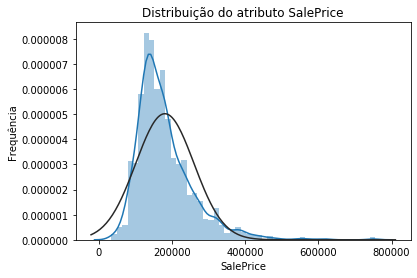

In [11]:
sns.distplot(train['SalePrice'] , fit=norm);

plt.ylabel('Frequência')
plt.title('Distribuição do atributo SalePrice')


#### Cálculo das métricas a serem usadas como base

Inicialmente é necessário definir a função para cálculo da média quadrática entre o logaritmo do valor previsto e o logaritmo do valor estimado.

In [12]:
def rmsle(y, y_pred):
    soma = 0.0
    for i,pred in enumerate(y_pred):
        if (pred > 0) & (y[i] > 0):
            soma += (np.log(pred + 1) - np.log(y[i] + 1)) ** 2.0
        elif pred <= 0:  
            print("Erro na linha {}. Valor previsto menor ou igual a zero: {}.".format(i, pred))
        elif y[i] <= 0:  
            print("Erro na linha {}. Valor original menor ou igual a zero: {}.".format(i, y[i]))
    return (soma * (1.0/len(y))) ** 0.5

Agora iremos calcular as métricas para um conjunto de dados que tem como valores previstos a média dos valores originais (aqui, conforme dito acima, o resultado será igual a zero). Na sequência, o mesmo procedimento será feito usando a mediana.

In [13]:
Y_media = np.full((len(Y_train_full)), np.mean(Y_train_full))
print("R2 Score para a previsão usando a média: {:10.3f}".format(r2_score(Y_train_full, Y_media)))
print("RMSLE para a previsão usando a média:    {:10.3f}".format(rmsle(Y_train_full, Y_media)))

R2 Score para a previsão usando a média:      0.000
RMSLE para a previsão usando a média:         0.408


In [14]:
Y_median = np.full((len(Y_train_full)), np.median(Y_train_full))
print("R2 Score para a previsão usando a mediana: {:10.3f}".format(r2_score(Y_train_full, Y_median)))
print("RMSLE para a previsão usando a mediana:    {:10.3f}".format(rmsle(Y_train_full, Y_median)))

R2 Score para a previsão usando a mediana:     -0.051
RMSLE para a previsão usando a mediana:         0.400


Com base nos cálculos acima, nosso objetivo será buscar projeções que apresentem, pelo menos, R2 Score maior do que 0.0 e RMSLE menor do que 0.4.

#### Análise de correlação

Iniciaremos com uma visualização da matriz de correlação.

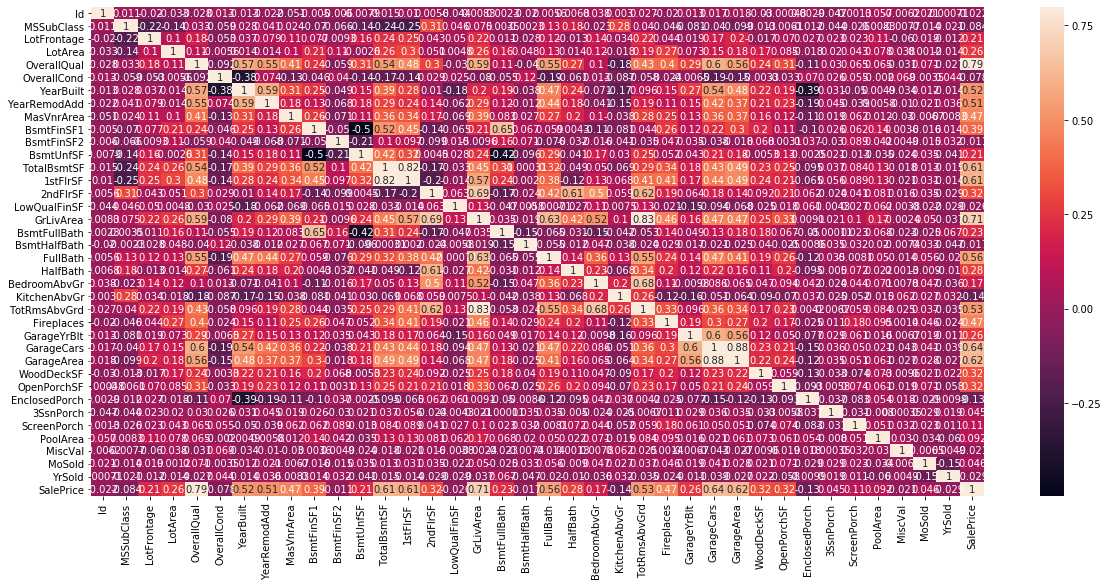

In [15]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True);

##### Listagem de atributos com graus de correlação maior do que 50% com o preço de venda

In [130]:
atributos_correlacao_preco_maior_50 = []
for id in corrmat.index:
    achouDiagonal = False
    if (id != "SalePrice") & (corrmat.loc[id]["SalePrice"] > 0.5):
        atributos_correlacao_preco_maior_50.append(id)
        print("Correlação de {:12s} com SalePrice: {:1.3f}".format(id, corrmat.loc[id]["SalePrice"]))

Correlação de OverallQual  com SalePrice: 0.791
Correlação de YearBuilt    com SalePrice: 0.523
Correlação de YearRemodAdd com SalePrice: 0.507
Correlação de TotalBsmtSF  com SalePrice: 0.614
Correlação de 1stFlrSF     com SalePrice: 0.606
Correlação de GrLivArea    com SalePrice: 0.709
Correlação de FullBath     com SalePrice: 0.561
Correlação de TotRmsAbvGrd com SalePrice: 0.534
Correlação de GarageCars   com SalePrice: 0.640
Correlação de GarageArea   com SalePrice: 0.623


##### Visualização de como cada um dos atributos acima está correlacionado com o preço de venda

Essa informação será útil posteriormente quando tratarmos de *outliers*.

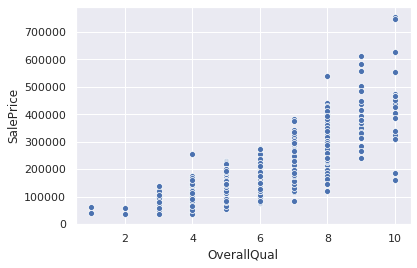

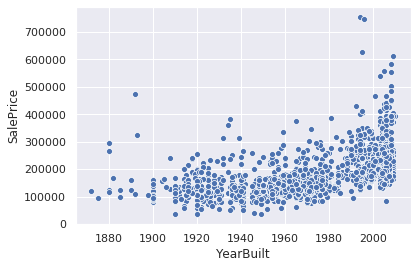

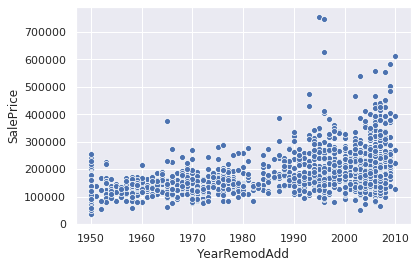

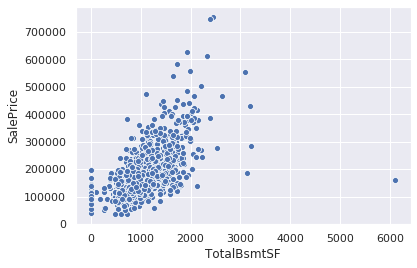

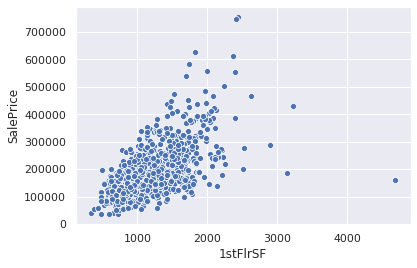

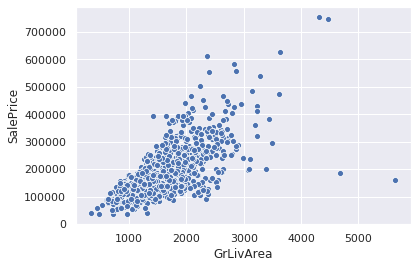

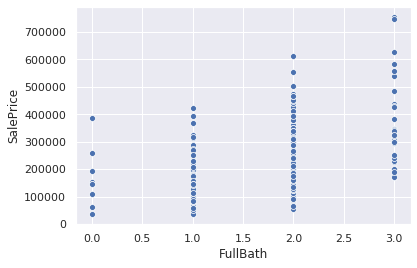

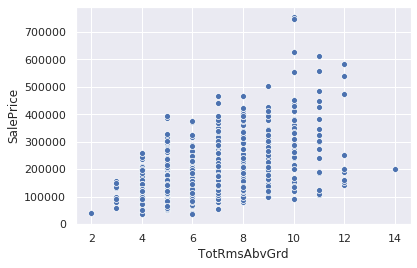

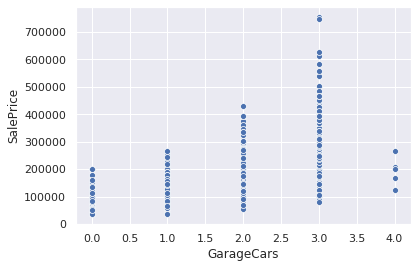

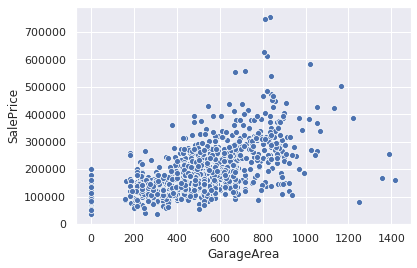

In [17]:
sns.set()
for attr in atributos_correlacao_preco_maior_50:
    sns.scatterplot(train[attr],train.SalePrice)
    plt.show()

##### Listagem de atributos com graus de correlação entre 10% e 50% com o preço de venda

In [18]:
atributos_correlacao_preco_entre_10_e_50 = []
for id in corrmat.index:
    achouDiagonal = False
    if (id != "SalePrice") & (0.1 < corrmat.loc[id]["SalePrice"] <= 0.5):
        atributos_correlacao_preco_entre_10_e_50.append(id)
        print("Correlação de {:12s} com SalePrice: {:1.3f}".format(id, corrmat.loc[id]["SalePrice"]))

Correlação de LotFrontage  com SalePrice: 0.210
Correlação de LotArea      com SalePrice: 0.264
Correlação de MasVnrArea   com SalePrice: 0.473
Correlação de BsmtFinSF1   com SalePrice: 0.386
Correlação de BsmtUnfSF    com SalePrice: 0.214
Correlação de 2ndFlrSF     com SalePrice: 0.319
Correlação de BsmtFullBath com SalePrice: 0.227
Correlação de HalfBath     com SalePrice: 0.284
Correlação de BedroomAbvGr com SalePrice: 0.168
Correlação de Fireplaces   com SalePrice: 0.467
Correlação de GarageYrBlt  com SalePrice: 0.261
Correlação de WoodDeckSF   com SalePrice: 0.324
Correlação de OpenPorchSF  com SalePrice: 0.316
Correlação de ScreenPorch  com SalePrice: 0.111


##### Visualização em barras dos 3 atributos com os maiores graus de correlação com o preço de venda.

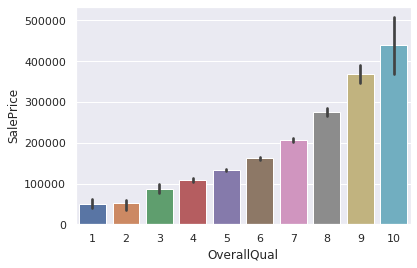

In [19]:
sns.barplot(train["OverallQual"],train.SalePrice)

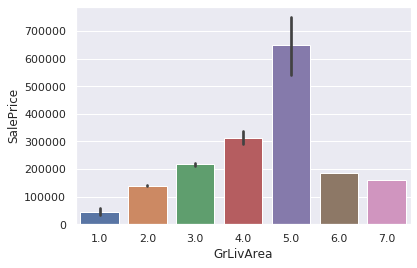

In [20]:
sns.barplot(round(train["GrLivArea"] / 1000 + 1),train.SalePrice)

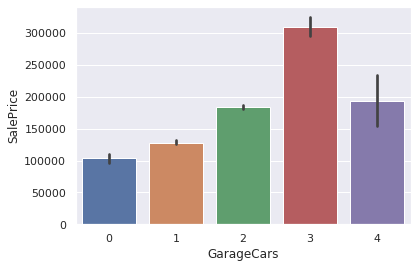

In [21]:
sns.barplot(train["GarageCars"],train.SalePrice)

Criação e exibição de um novo DataFrame apenas com os atributos que possuem correlação maior do que 50% com o preço de venda.

In [22]:
X_atributos_correlacao_preco_maior_50 = X_train_full[atributos_correlacao_preco_maior_50]

X_atributos_correlacao_preco_maior_50.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
0,7,2003,2003,856,856,1710,2,8,2,548
1,6,1976,1976,1262,1262,1262,2,6,2,460
2,7,2001,2002,920,920,1786,2,6,2,608
3,7,1915,1970,756,961,1717,1,7,3,642
4,8,2000,2000,1145,1145,2198,2,9,3,836


##### Regressões com atributos que possuem correlação maior do que 50% com o preço de venda

Serão realizadas agora regressões com base nos atributos que possuem correlação maior do que 50% com o preço de venda. 

Não será realizado nenhum tipo de otimização.

Os melhores índices alcançados, se melhores do que os obtidos anteriormente com a média e a mediana, serão usados como benchmark para as futuras tentativas de melhorar os resultados.

*Preparação dos dados* 

Como todos os atributos são numéricos, usaremos a função MinMaxScaler para que todos fiquem entre 0 e 1.

In [168]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X_atributos_correlacao_preco_maior_50)

*Divisão entre conjunto de treinamento e testes* 

Usaremos a função train_test_split para dividir o conjunto de dados de treinamento entre 2:
- 70% para treinamento;
- 30% para testes.

In [169]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_train_full, test_size=0.3, random_state = 0)

*Função genérica*

A função abaixo serve para generalizar a execução e visualização dos resultados de regressões usando diferentes modelos.

In [170]:
def regressao(model, _X_train, _Y_train, _X_test, _Y_test):
    reg = model.fit(_X_train, _Y_train)

    Y_predicted = reg.predict(_X_test)

    df_Y_predicted = pd.Series(Y_predicted)

    df_Y_predicted = pd.DataFrame(Y_predicted)
    df_Y_predicted.columns = ["previsto"]
    df_Y_predicted[df_Y_predicted["previsto"] <= 0] = np.mean(_Y_train)

    print("R2 Score: {:10.3f}".format(r2_score(_Y_test.values, df_Y_predicted.round(0).values)))
    print("RMSLE:    {:10.3f}".format(rmsle(_Y_test.values, df_Y_predicted.values)[0]))

*Linear Regression*

In [171]:
regressao(LinearRegression(), X_train, Y_train.values, X_test, Y_test)

R2 Score:      0.701
RMSLE:         0.212


*Decision Tree*

In [27]:
regressao(DecisionTreeClassifier(), X_train, Y_train.values, X_test, Y_test)

R2 Score:      0.682
RMSLE:         0.237


*LassoCV*

In [28]:
X, y = make_regression(noise=4, random_state=0)

regressao(LassoCV(cv=5, random_state=0), X_train, Y_train.values, X_test, Y_test)

R2 Score:      0.705
RMSLE:         0.208


*ElasticNet*

In [29]:
regressao(ElasticNet(random_state=0), X_train, Y_train.values, X_test, Y_test)

R2 Score:      0.267
RMSLE:         0.330


*Neural Network*

In [32]:
model = Sequential([
    Dense(75, activation='relu', input_shape=(10,)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, kernel_initializer='normal'),
])

model.compile(loss='mean_squared_error', optimizer='adam')

print(datetime.datetime.now())

hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_test, Y_test))

print(datetime.datetime.now())

2019-08-01 13:43:29.781672
Train on 1022 samples, validate on 438 samples
Epoch 1/100
1022/1022 [==============================] - 1s 841us/step - loss: 38711106181.2603 - val_loss: 39804758773.4795
Epoch 2/100
1022/1022 [==============================] - 0s 44us/step - loss: 38710286091.5225 - val_loss: 39801966087.0137
Epoch 3/100
1022/1022 [==============================] - 0s 48us/step - loss: 38696153901.5890 - val_loss: 39760390359.0868
Epoch 4/100
1022/1022 [==============================] - 0s 50us/step - loss: 38545327242.2701 - val_loss: 39381162591.8539
Epoch 5/100
1022/1022 [==============================] - 0s 74us/step - loss: 37488093869.3386 - val_loss: 37066140816.9498
Epoch 6/100
1022/1022 [==============================] - 0s 48us/step - loss: 32393936713.6438 - val_loss: 27603343949.1507
Epoch 7/100
1022/1022 [==============================] - 0s 57us/step - loss: 17263585302.0431 - val_loss: 7795558138.1553
Epoch 8/100
1022/1022 [==============================] - 0

Epoch 67/100
1022/1022 [==============================] - 0s 54us/step - loss: 1561259853.6517 - val_loss: 2129426045.0776
Epoch 68/100
1022/1022 [==============================] - 0s 53us/step - loss: 1553652814.6536 - val_loss: 2112174376.9132
Epoch 69/100
1022/1022 [==============================] - 0s 46us/step - loss: 1550249894.9511 - val_loss: 2103467970.0457
Epoch 70/100
1022/1022 [==============================] - 0s 52us/step - loss: 1528047114.5205 - val_loss: 2100236947.2877
Epoch 71/100
1022/1022 [==============================] - 0s 53us/step - loss: 1517047508.9159 - val_loss: 2088890460.3470
Epoch 72/100
1022/1022 [==============================] - 0s 56us/step - loss: 1503232150.7945 - val_loss: 2091336050.5571
Epoch 73/100
1022/1022 [==============================] - 0s 53us/step - loss: 1508705859.6321 - val_loss: 2078610389.9178
Epoch 74/100
1022/1022 [==============================] - 0s 53us/step - loss: 1497776787.6634 - val_loss: 2073932283.3242
Epoch 75/100
102

In [33]:
model.evaluate(X_test, Y_test)

Y_predicted = model.predict(X_test)

df_Y_predicted = pd.Series(Y_predicted.tolist())

df_Y_predicted = pd.DataFrame(Y_predicted)
df_Y_predicted.columns = ["previsto"]
df_Y_predicted[df_Y_predicted["previsto"] <= 0] = np.mean(Y_train_full)

print("R2 Score: {:10.3f}".format(r2_score(Y_test.values, df_Y_predicted.round(0).values)))
print("RMSLE:    {:10.3f}".format(rmsle(Y_test.values, df_Y_predicted.values)[0]))

438/438 [==============================] - 0s 34us/step
R2 Score:      0.702
RMSLE:         0.205


Houve uma melhora significativa nos índices. O modelo linear com melhor resultado foi a regressão linear ordinária das menores raizes (*LinearRegression*). A rede neural apresentou resultado ainda melhor com 15.00 *epochs*, portanto passará a ser nosso *benchmark*.

#### Evoluindo...

#### Pré-processamento - parte 2

##### Remoção de outliers

In [159]:
filtro = list(atributos_correlacao_preco_maior_50)
filtro.append("SalePrice")

In [160]:
train_sem_outliers = train

for col in filtro:
    z = np.abs(stats.zscore(train_sem_outliers[col]))
    train_sem_outliers = train_sem_outliers.iloc[np.where(z < 3)[0]]
train_sem_outliers.shape

(1391, 81)

In [172]:
Y_train_sem_outliers = train_sem_outliers["SalePrice"]
X_train_sem_outliers = train_sem_outliers[atributos_correlacao_preco_maior_50]
X_scale_sem_outliers = min_max_scaler.fit_transform(X_train_sem_outliers)
X_train, X_test, Y_train, Y_test = train_test_split(X_scale_sem_outliers, Y_train_sem_outliers, test_size=0.3, random_state = 0)
regressao(LinearRegression(), X_scale_sem_outliers, Y_train_sem_outliers.values, X_test, Y_test)

R2 Score:      0.817
RMSLE:         0.175


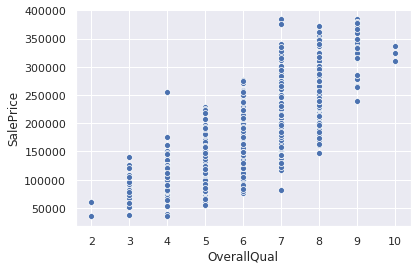

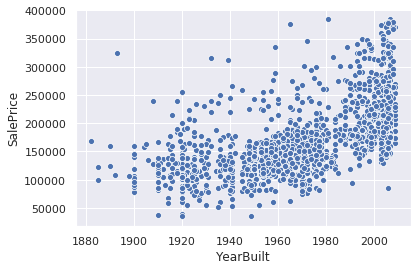

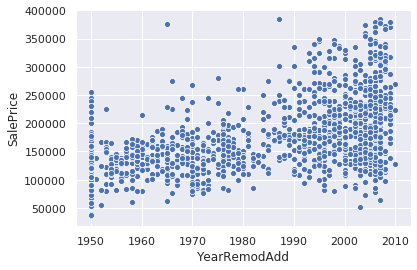

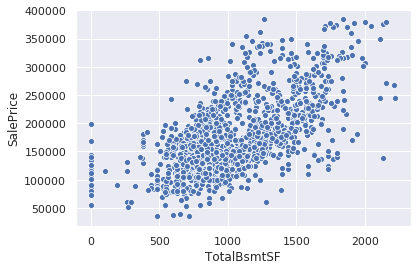

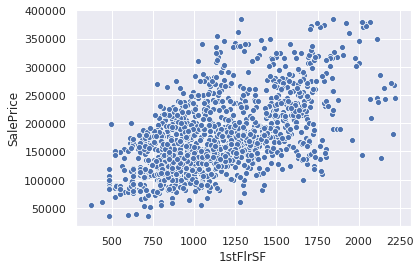

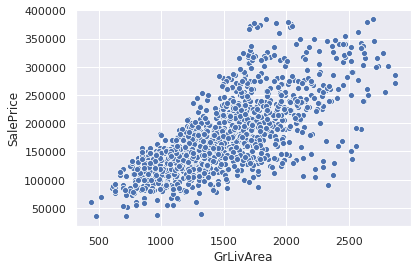

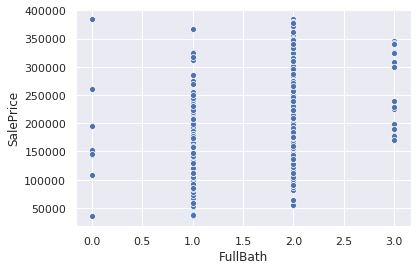

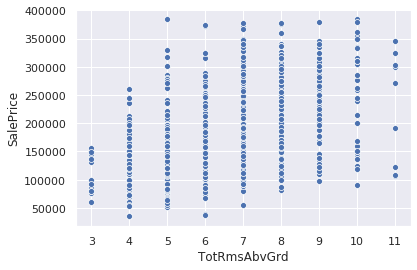

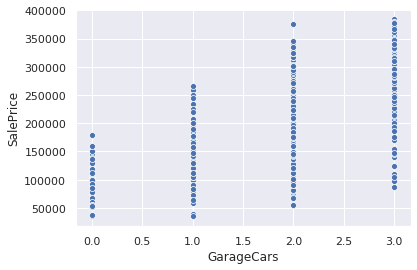

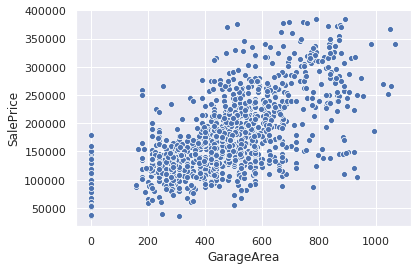

In [156]:
sns.set()
for attr in atributos_correlacao_preco_maior_50:
    sns.scatterplot(train_sem_outliers[attr],train_sem_outliers.SalePrice)
    plt.show()

In [ ]:
train_sem_outliers

##### Separação entre atributos categóricos e numéricos

In [173]:
atributos_categoricos = train_sem_outliers.select_dtypes(include=['object']).columns
atributos_categoricos

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [174]:
atributos_numericos = train_sem_outliers.select_dtypes(exclude = ["object"]).columns
atributos_numericos

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [175]:
train_numerico = train_sem_outliers[atributos_numericos].drop("SalePrice", axis=1)
train_categorico = train_sem_outliers[atributos_categoricos]

##### Tratamento das assimetrias 

Vamos ordenar os atributos ordem decrescente de assimetria.

In [176]:
assimetria = train_numerico.apply(lambda x: skew(x))
assimetria.sort_values(ascending=False)

MiscVal          29.115699
PoolArea         21.793020
LotArea          13.109708
3SsnPorch        10.667415
LowQualFinSF     10.438691
KitchenAbvGr      4.657103
BsmtFinSF2        4.303674
BsmtHalfBath      4.113736
ScreenPorch       4.029569
EnclosedPorch     2.841887
MasVnrArea        2.684079
OpenPorchSF       2.397688
WoodDeckSF        1.600833
MSSubClass        1.390503
BsmtUnfSF         0.863872
OverallCond       0.739404
2ndFlrSF          0.730514
HalfBath          0.698389
BsmtFinSF1        0.681109
Fireplaces        0.667579
BsmtFullBath      0.628193
1stFlrSF          0.620751
GrLivArea         0.512476
TotRmsAbvGrd      0.412386
MoSold            0.221973
OverallQual       0.135151
TotalBsmtSF       0.109683
YrSold            0.097245
Id               -0.001253
LotFrontage      -0.020480
BedroomAbvGr     -0.033718
FullBath         -0.041668
GarageArea       -0.062739
GarageCars       -0.448420
YearRemodAdd     -0.471064
YearBuilt        -0.537706
GarageYrBlt      -3.931213
d

*Visualização do atributo com maior assimetria* 

Text(0.5, 1.0, 'Distribuição do atributo MiscVal')

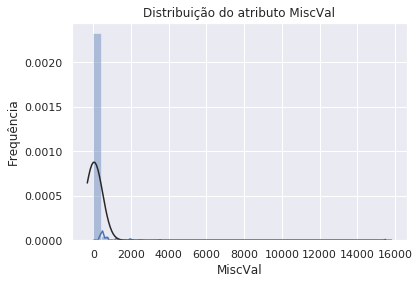

In [177]:
sns.distplot(train_numerico['MiscVal'] , fit=norm);

plt.ylabel('Frequência')
plt.title('Distribuição do atributo MiscVal')

*Ajuste de todos os atributos com assimetria maior do que 0.5* 

In [178]:
assimetria = train_numerico.apply(lambda x: skew(x))

for atributo in assimetria[assimetria > 0.5].index:
    train_numerico.loc[:,atributo] = train_numerico[atributo].apply(lambda x: np.log1p(x))
    print("Ajustando o atributo {}".format(atributo))

print("--------------------------------") 
print("Atributos ajustados com sucesso!") 

Ajustando o atributo MSSubClass
Ajustando o atributo LotArea
Ajustando o atributo OverallCond
Ajustando o atributo MasVnrArea
Ajustando o atributo BsmtFinSF1
Ajustando o atributo BsmtFinSF2
Ajustando o atributo BsmtUnfSF
Ajustando o atributo 1stFlrSF
Ajustando o atributo 2ndFlrSF
Ajustando o atributo LowQualFinSF
Ajustando o atributo GrLivArea
Ajustando o atributo BsmtFullBath
Ajustando o atributo BsmtHalfBath
Ajustando o atributo HalfBath
Ajustando o atributo KitchenAbvGr
Ajustando o atributo Fireplaces
Ajustando o atributo WoodDeckSF
Ajustando o atributo OpenPorchSF
Ajustando o atributo EnclosedPorch
Ajustando o atributo 3SsnPorch
Ajustando o atributo ScreenPorch
Ajustando o atributo PoolArea
Ajustando o atributo MiscVal
--------------------------------
Atributos ajustados com sucesso!


*Visualização de como ficou o atributo que apresentava a maior assimetria* 

Text(0.5, 1.0, 'Distribuição do atributo MiscVal')

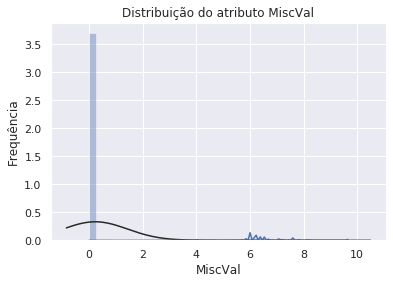

In [179]:
sns.distplot(train_numerico['MiscVal'] , fit=norm);

plt.ylabel('Frequência')
plt.title('Distribuição do atributo MiscVal')

##### Normalização dos dados numéricos

In [180]:
train_numerico = pd.DataFrame(min_max_scaler.fit_transform(train_numerico), columns=train_numerico.columns)

##### One-hot encode dos dados categóricos

In [181]:
print("Formato dos dados categóricos antes da transformação: {}".format(train_categorico.shape))
train_categorico = pd.get_dummies(train_categorico)
print("Formato dos dados categóricos após a transformação:   {}".format(train_categorico.shape))

Formato dos dados categóricos antes da transformação: (1391, 43)
Formato dos dados categóricos após a transformação:   (1391, 261)


##### Geração do DataFrame contendo os dados categóricos e numéricos tratados

In [182]:
train_tratado = pd.concat([train_categorico,train_numerico],axis=1)
train_tratado.shape

(1459, 298)

###### PCA  
Inicialmente iremos executar a análise com o número total de atributos e analisar no resultado como os componentes principais vão explicando a variância cumulativamente.

In [184]:
pca = PCA(n_components=200)
pca.fit(train_tratado)
X_PCA_train = pca.transform(train_tratado)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

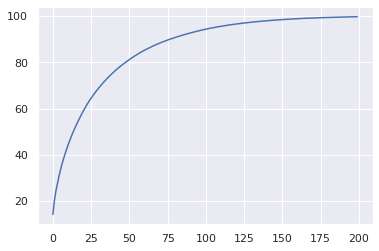

In [45]:
variancia_acumulada = pd.Series(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
sns.lineplot(data=variancia_acumulada)

Percebe-se que com cerca de 75 componentes já é possível explicar 90% da variância. 

Faremos, então, um teste de regressão com 75 componentes.

In [46]:
pca = PCA(n_components=75)
pca.fit(train_tratado)
X_PCA_train = pca.transform(train_tratado)

X_train, X_test, Y_train, Y_test = train_test_split(X_PCA_train, Y_train_full, test_size=0.3, random_state=0)

In [47]:
regressao(LinearRegression(), X_train, Y_train.values, X_test, Y_test)

R2 Score:      0.784
RMSLE:         0.185


In [48]:
model = Sequential([
    Dense(75, activation='relu', input_shape=(75,)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, kernel_initializer='normal'),
])

model.compile(loss='mean_squared_error', optimizer='adam')

print(datetime.datetime.now())

hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_test, Y_test))

print(datetime.datetime.now())

2019-08-01 13:43:53.627198
Train on 1022 samples, validate on 438 samples
Epoch 1/100
1022/1022 [==============================] - 1s 878us/step - loss: 38711089749.1663 - val_loss: 39804682726.2831
Epoch 2/100
1022/1022 [==============================] - 0s 52us/step - loss: 38709730931.2250 - val_loss: 39799879689.3516
Epoch 3/100
1022/1022 [==============================] - 0s 55us/step - loss: 38682669865.5812 - val_loss: 39718522562.0457
Epoch 4/100
1022/1022 [==============================] - 0s 48us/step - loss: 38360459628.7123 - val_loss: 38894470728.4749
Epoch 5/100
1022/1022 [==============================] - 0s 59us/step - loss: 35979536283.8043 - val_loss: 33765781803.2511
Epoch 6/100
1022/1022 [==============================] - 0s 54us/step - loss: 24791096891.1155 - val_loss: 15624072636.2009
Epoch 7/100
1022/1022 [==============================] - 0s 55us/step - loss: 5343945297.4090 - val_loss: 1978213424.5114
Epoch 8/100
1022/1022 [==============================] - 0s

1022/1022 [==============================] - 0s 53us/step - loss: 426082664.7045 - val_loss: 1208911386.8858
Epoch 68/100
1022/1022 [==============================] - 0s 50us/step - loss: 413817884.1174 - val_loss: 1203242622.8311
Epoch 69/100
1022/1022 [==============================] - 0s 50us/step - loss: 410404454.7006 - val_loss: 1218916205.8813
Epoch 70/100
1022/1022 [==============================] - 0s 51us/step - loss: 407194223.9061 - val_loss: 1217113398.3562
Epoch 71/100
1022/1022 [==============================] - 0s 43us/step - loss: 399438338.7554 - val_loss: 1206128600.8402
Epoch 72/100
1022/1022 [==============================] - 0s 54us/step - loss: 395256458.5519 - val_loss: 1209655440.3653
Epoch 73/100
1022/1022 [==============================] - 0s 44us/step - loss: 391445975.9217 - val_loss: 1201339490.7763
Epoch 74/100
1022/1022 [==============================] - 0s 53us/step - loss: 384761098.7084 - val_loss: 1200447908.8219
Epoch 75/100
1022/1022 [=============

In [49]:
model.evaluate(X_test, Y_test)

Y_predicted = model.predict(X_test)

df_Y_predicted = pd.Series(Y_predicted.tolist())

df_Y_predicted = pd.DataFrame(Y_predicted)
df_Y_predicted.columns = ["previsto"]
df_Y_predicted[df_Y_predicted["previsto"] <= 0] = np.mean(Y_train_full)

print("R2 Score: {:10.3f}".format(r2_score(Y_test.values, df_Y_predicted.round(0).values)))
print("RMSLE:    {:10.3f}".format(rmsle(Y_test.values, df_Y_predicted.values)[0]))

438/438 [==============================] - 0s 39us/step
R2 Score:      0.825
RMSLE:         0.164


##### Pares de atributo com grau de correlação entre si maior do que 50%.  

Para tais pares, indicaremos qual deles tem mais correlação com o valor de venda.

In [ ]:
print("-----------------------------------------------------------------")
for id in corrmat.index:
    achouDiagonal = False
    imprimiu_algo = False
    for col in corrmat.columns:
        if id == col:
            achouDiagonal = True
        if (id != "SalePrice") & (col != "SalePrice") & (id != col) & (achouDiagonal) & (corrmat.loc[id][col] > 0.5):
            imprimiu_algo = True
            print("Id: {}, Col: {}".format(id, col))
            if corrmat.loc[id]["SalePrice"] > corrmat.loc[col]["SalePrice"]:
                print("O atributo com maior correlação com o preço é: {}: {:7.3f}. A correlação de {} é {:7.3f}".format(id, corrmat.loc[id]["SalePrice"], col, corrmat.loc[col]["SalePrice"]))
                
            else:
                print("O atributo com maior correlação com o preço é: {}: {:7.3f}. A correlação de {} é {:7.3f}".format(col, corrmat.loc[col]["SalePrice"], id, corrmat.loc[id]["SalePrice"]))
            print("")
    if imprimiu_algo:
        print("-----------------------------------------------------------------")

Considerando os resultados acima, vamos remover os atributos BedroomAbvGr, BsmtFullBath e HalfBath, pois são bem representados por outros atributos, devida à alta correlação, e possuem correlações abaixo de 30% com o preço de venda.

In [ ]:
X_train = X_train.drop("BedroomAbvGr", axis=1)
X_train = X_train.drop("BsmtFullBath", axis=1)
X_train = X_train.drop("HalfBath", axis=1)

In [ ]:
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=10)

pca.fit(X_train)  
X_PCA_train = pca.transform(X_train)

np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

pca.fit(X_test)  
X_PCA_test = pca.transform(X_test)

print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

regressao(LinearRegression(), X_PCA_train[:,0:7], Y_train.values, X_PCA_test[:,0:7], Y_test)

# regressao(LinearRegression(), X_train, Y_train.values, X_test, Y_test)

##### Visualização da correlação entre os atributos que têm grau de correlação com o preço de venda maior do que 50%

In [ ]:
plt.figure(figsize=(10,10))
g = sns.heatmap(train[atributos_correlacao_preco_maior_50].corr(),annot=True,cmap="RdYlGn")

Vamos agora analisar quais atributos apresentam grau de correlação maior do que 50%.

In [ ]:
for id in corrmat.index:
    if (id != 'SalePrice') &(corrmat.loc[id]['SalePrice'] > 0.3):
        print(id)

In [ ]:
# train = train[["LotArea","OverallCond", "TotalBsmtSF", "FullBath", "HalfBath","BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageArea", "SalePrice"]]
train_array = train.values
# train_array

# list(train)
# train_array.shape

X = train_array[:,0:80]

Y = train_array[:,80]

# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# X_scale = min_max_scaler.fit_transform(X)

In [ ]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
# X_train[0]

In [ ]:
reg = LinearRegression().fit(X_train, Y_train)

Y_resultado_2 = reg.predict(X_test)

rmsle(Y_test, Y_resultado_2)

In [ ]:
reg = LinearRegression().fit(X_train, Y_train)

Y_resultado_2 = reg.predict(X_test)

rmsle(Y_test, Y_resultado_2)

In [ ]:
train = pd.read_csv("train.csv")
list(train)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = pd.DataFrame(min_max_scaler.fit_transform(X_atributos_correlacao_preco_maior_50), columns=X_atributos_correlacao_preco_maior_50.columns)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_train_full, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

reg = DecisionTreeClassifier().fit(X_train, Y_train.values)

Y_predicted = reg.predict(X_val)

df_Y_predicted = pd.Series(Y_predicted)

df_Y_predicted = pd.DataFrame(Y_predicted)
df_Y_predicted.columns = ["previsto"]
df_Y_predicted[df_Y_predicted["previsto"] <= 0] = np.mean(Y_train_full)

print("R2 Score: {:10.3f}".format(r2_score(Y_val.values, df_Y_predicted.round(0).values)))
print("RMSLE:    {:10.3f}".format(rmsle(Y_val.values, df_Y_predicted.values)[0]))

Usar Root-Mean-Squared-Error (RMSE)  
sklearn.metrics.mean_squared_error(y_true, y_pred, sample_weight=None, multioutput=’uniform_average’)[source]

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(iris.data, iris.target)

reg = LinearRegression().fit(X_train, Y_train)

Y_resultado_2 = reg.predict(X_test)

rmsle(Y_test, Y_resultado_2)

[Descrição dos dados](data_description.txt)

In [ ]:
train = train[["LotArea","OverallCond", "TotalBsmtSF", "FullBath", "HalfBath","BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageArea", "SalePrice"]]
train_array = train.values
# train_array

# list(train)

X = train_array[:,0:9]
Y = train_array[:,9]

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [ ]:
Y_train

In [ ]:
# [1760425580.7123287, 0.0]
model.evaluate(X_test, Y_test)
Y_resultado = model.predict(X_test)

In [ ]:
Y_resultado = model.predict(X_test)

In [ ]:
df_Y = pd.DataFrame(Y_resultado)
df_Y.columns = ["projetado"]

df_Y_test = pd.DataFrame(Y_test)
df_Y_test.columns = ["original"]

df_join = df_Y.join(df_Y_test, lsuffix='_caller', rsuffix='_other')
df_join["diferenca"] = df_join["projetado"] - df_join["original"]
df_join

In [ ]:
pd.DataFrame(Y).head()

In [ ]:
df_Y_cheat = df_Y_test["original"] - 7000
# df_Y_cheat.columns = ["cheat"]
# df_Y_cheat
# rmsle(Y_test, Y_cheat)

# df_join_2 = df_Y_test.join(df_Y_cheat, lsuffix='_caller', rsuffix='_other')
# df_join_2["diferenca"] = df_join_2["original_caller"] - df_join_2["original_other"]
# df_Y_test["original"].values
# df_Y_cheat.values
# rmsle(df_Y_test["original"].values, df_Y_cheat.values)

rmsle(Y_test, Y_resultado)

In [ ]:
X, y = make_regression(noise=4, random_state=0)
reg2 = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)

Y_resultado_4 = reg2.predict(X_test)

rmsle(Y_test, Y_resultado_4)

In [ ]:
X, y = make_regression(noise=4, random_state=0)
reg2 = LassoLars(alpha=0.01).fit(X_train, Y_train)

Y_resultado_4 = reg2.predict(X_test)

rmsle(Y_test, Y_resultado_4)

In [ ]:
X, y = make_regression(n_features=2, random_state=0)
reg3 = ElasticNet(random_state=0)
reg3.fit(X_train, Y_train)  
Y_resultado_5 = reg3.predict(X_test)
rmsle(Y_test, Y_resultado_5)

In [ ]:
Y_resultado_6 = [np.mean(Y_test) for i in range(len(X_test))]
rmsle(Y_test, Y_resultado_6)

In [ ]:
Y_resultado_7 = np.full((len(X_test)), np.median(Y_test))
rmsle(Y_test, Y_resultado_7)

#### Descrição dos dados

````
MSSubClass: Identifies the type of dwelling involved in the sale.    

        20    1-STORY 1946 & NEWER ALL STYLES
        30    1-STORY 1945 & OLDER
        40    1-STORY W/FINISHED ATTIC ALL AGES
        45    1-1/2 STORY - UNFINISHED ALL AGES
        50    1-1/2 STORY FINISHED ALL AGES
        60    2-STORY 1946 & NEWER
        70    2-STORY 1945 & OLDER
        75    2-1/2 STORY ALL AGES
        80    SPLIT OR MULTI-LEVEL
        85    SPLIT FOYER
        90    DUPLEX - ALL STYLES AND AGES
       120    1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150    1-1/2 STORY PUD - ALL AGES
       160    2-STORY PUD - 1946 & NEWER
       180    PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190    2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
        
       A    Agriculture
       C    Commercial
       FV   Floating Village Residential
       I    Industrial
       RH   Residential High Density
       RL   Residential Low Density
       RP   Residential Low Density Park 
       RM   Residential Medium Density
    
LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property

       Grvl    Gravel    
       Pave    Paved
           
Alley: Type of alley access to property
    
       Grvl    Gravel
       Pave    Paved
       NA      No alley access
        
LotShape: General shape of property

       Reg    Regular    
       IR1    Slightly irregular
       IR2    Moderately Irregular
       IR3    Irregular
       
LandContour: Flatness of the property

       Lvl    Near Flat/Level    
       Bnk    Banked - Quick and significant rise from street grade to building
       HLS    Hillside - Significant slope from side to side
       Low    Depression
        
Utilities: Type of utilities available
        
       AllPub   All public Utilities (E,G,W,& S)    
       NoSewr   Electricity, Gas, and Water (Septic Tank)
       NoSeWa   Electricity and Gas Only
       ELO      Electricity only    
    
LotConfig: Lot configuration

       Inside   Inside lot
       Corner   Corner lot
       CulDSac  Cul-de-sac
       FR2      Frontage on 2 sides of property
       FR3      Frontage on 3 sides of property
    
LandSlope: Slope of property
        
       Gtl    Gentle slope
       Mod    Moderate Slope    
       Sev    Severe Slope
    
Neighborhood: Physical locations within Ames city limits

       Blmngtn    Bloomington Heights
       Blueste    Bluestem
       BrDale     Briardale
       BrkSide    Brookside
       ClearCr    Clear Creek
       CollgCr    College Creek
       Crawfor    Crawford
       Edwards    Edwards
       Gilbert    Gilbert
       IDOTRR     Iowa DOT and Rail Road
       MeadowV    Meadow Village
       Mitchel    Mitchell
       Names      North Ames
       NoRidge    Northridge
       NPkVill    Northpark Villa
       NridgHt    Northridge Heights
       NWAmes     Northwest Ames
       OldTown    Old Town
       SWISU      South & West of Iowa State University
       Sawyer     Sawyer
       SawyerW    Sawyer West
       Somerst    Somerset
       StoneBr    Stone Brook
       Timber     Timberland
       Veenker    Veenker
            
Condition1: Proximity to various conditions
    
       Artery   Adjacent to arterial street
       Feedr    Adjacent to feeder street    
       Norm     Normal    
       RRNn     Within 200' of North-South Railroad
       RRAn     Adjacent to North-South Railroad
       PosN     Near positive off-site feature--park, greenbelt, etc.
       PosA     Adjacent to postive off-site feature
       RRNe     Within 200' of East-West Railroad
       RRAe     Adjacent to East-West Railroad
    
Condition2: Proximity to various conditions (if more than one is present)
        
       Artery   Adjacent to arterial street
       Feedr    Adjacent to feeder street    
       Norm     Normal    
       RRNn     Within 200' of North-South Railroad
       RRAn     Adjacent to North-South Railroad
       PosN     Near positive off-site feature--park, greenbelt, etc.
       PosA     Adjacent to postive off-site feature
       RRNe     Within 200' of East-West Railroad
       RRAe     Adjacent to East-West Railroad
    
BldgType: Type of dwelling
        
       1Fam     Single-family Detached    
       2FmCon   Two-family Conversion; originally built as one-family dwelling
       Duplx    Duplex
       TwnhsE   Townhouse End Unit
       TwnhsI   Townhouse Inside Unit
    
HouseStyle: Style of dwelling
    
       1Story    One story
       1.5Fin    One and one-half story: 2nd level finished
       1.5Unf    One and one-half story: 2nd level unfinished
       2Story    Two story
       2.5Fin    Two and one-half story: 2nd level finished
       2.5Unf    Two and one-half story: 2nd level unfinished
       SFoyer    Split Foyer
       SLvl      Split Level
    
OverallQual: Rates the overall material and finish of the house

       10   Very Excellent
       9    Excellent
       8    Very Good
       7    Good
       6    Above Average
       5    Average
       4    Below Average
       3    Fair
       2    Poor
       1    Very Poor
    
OverallCond: Rates the overall condition of the house

       10   Very Excellent
       9    Excellent
       8    Very Good
       7    Good
       6    Above Average    
       5    Average
       4    Below Average    
       3    Fair
       2    Poor
       1    Very Poor
        
YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

RoofStyle: Type of roof

       Flat       Flat
       Gable      Gable
       Gambrel    Gabrel (Barn)
       Hip        Hip
       Mansard    Mansard
       Shed       Shed
        
RoofMatl: Roof material

       ClyTile    Clay or Tile
       CompShg    Standard (Composite) Shingle
       Membran    Membrane
       Metal      Metal
       Roll       Roll
       Tar&Grv    Gravel & Tar
       WdShake    Wood Shakes
       WdShngl    Wood Shingles
        
Exterior1st: Exterior covering on house

       AsbShng    Asbestos Shingles
       AsphShn    Asphalt Shingles
       BrkComm    Brick Common
       BrkFace    Brick Face
       CBlock     Cinder Block
       CemntBd    Cement Board
       HdBoard    Hard Board
       ImStucc    Imitation Stucco
       MetalSd    Metal Siding
       Other      Other
       Plywood    Plywood
       PreCast    PreCast    
       Stone      Stone
       Stucco     Stucco
       VinylSd    Vinyl Siding
       Wd Sdng    Wood Siding
       WdShing    Wood Shingles
    
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng    Asbestos Shingles
       AsphShn    Asphalt Shingles
       BrkComm    Brick Common
       BrkFace    Brick Face
       CBlock     Cinder Block
       CemntBd    Cement Board
       HdBoard    Hard Board
       ImStucc    Imitation Stucco
       MetalSd    Metal Siding
       Other      Other
       Plywood    Plywood
       PreCast    PreCast
       Stone      Stone
       Stucco     Stucco
       VinylSd    Vinyl Siding
       Wd Sdng    Wood Siding
       WdShing    Wood Shingles
    
MasVnrType: Masonry veneer type

       BrkCmn    Brick Common
       BrkFace   Brick Face
       CBlock    Cinder Block
       None      None
       Stone     Stone
    
MasVnrArea: Masonry veneer area in square feet

ExterQual: Evaluates the quality of the material on the exterior 
        
       Ex    Excellent
       Gd    Good
       TA    Average/Typical
       Fa    Fair
       Po    Poor
        
ExterCond: Evaluates the present condition of the material on the exterior
        
       Ex    Excellent
       Gd    Good
       TA    Average/Typical
       Fa    Fair
       Po    Poor
        
Foundation: Type of foundation
        
       BrkTil   Brick & Tile
       CBlock   Cinder Block
       PConc    Poured Contrete    
       Slab     Slab
       Stone    Stone
       Wood     Wood
        
BsmtQual: Evaluates the height of the basement

       Ex    Excellent (100+ inches)    
       Gd    Good (90-99 inches)
       TA    Typical (80-89 inches)
       Fa    Fair (70-79 inches)
       Po    Poor (<70 inches
       NA    No Basement
        
BsmtCond: Evaluates the general condition of the basement

       Ex    Excellent
       Gd    Good
       TA    Typical - slight dampness allowed
       Fa    Fair - dampness or some cracking or settling
       Po    Poor - Severe cracking, settling, or wetness
       NA    No Basement
    
BsmtExposure: Refers to walkout or garden level walls

       Gd    Good Exposure
       Av    Average Exposure (split levels or foyers typically score average or above)    
       Mn    Mimimum Exposure
       No    No Exposure
       NA    No Basement
    
BsmtFinType1: Rating of basement finished area

       GLQ    Good Living Quarters
       ALQ    Average Living Quarters
       BLQ    Below Average Living Quarters    
       Rec    Average Rec Room
       LwQ    Low Quality
       Unf    Unfinshed
       NA     No Basement
        
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ    Good Living Quarters
       ALQ    Average Living Quarters
       BLQ    Below Average Living Quarters    
       Rec    Average Rec Room
       LwQ    Low Quality
       Unf    Unfinshed
       NA     No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating
        
       Floor    Floor Furnace
       GasA     Gas forced warm air furnace
       GasW     Gas hot water or steam heat
       Grav     Gravity furnace    
       OthW     Hot water or steam heat other than gas
       Wall     Wall furnace
        
HeatingQC: Heating quality and condition

       Ex    Excellent
       Gd    Good
       TA    Average/Typical
       Fa    Fair
       Po    Poor
        
CentralAir: Central air conditioning

       N    No
       Y    Yes
        
Electrical: Electrical system

       SBrkr    Standard Circuit Breakers & Romex
       FuseA    Fuse Box over 60 AMP and all Romex wiring (Average)    
       FuseF    60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP    60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix      Mixed
        
1stFlrSF: First Floor square feet
 
2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Bedrooms above grade (does NOT include basement bedrooms)

Kitchen: Kitchens above grade

KitchenQual: Kitchen quality

       Ex    Excellent
       Gd    Good
       TA    Typical/Average
       Fa    Fair
       Po    Poor
           
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ    Typical Functionality
       Min1   Minor Deductions 1
       Min2   Minor Deductions 2
       Mod    Moderate Deductions
       Maj1   Major Deductions 1
       Maj2   Major Deductions 2
       Sev    Severely Damaged
       Sal    Salvage only
        
Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

       Ex    Excellent - Exceptional Masonry Fireplace
       Gd    Good - Masonry Fireplace in main level
       TA    Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa    Fair - Prefabricated Fireplace in basement
       Po    Poor - Ben Franklin Stove
       NA    No Fireplace
        
GarageType: Garage location
        
       2Types    More than one type of garage
       Attchd    Attached to home
       Basment   Basement Garage
       BuiltIn   Built-In (Garage part of house - typically has room above garage)
       CarPort   Car Port
       Detchd    Detached from home
       NA        No Garage
        
GarageYrBlt: Year garage was built
        
GarageFinish: Interior finish of the garage

       Fin    Finished
       RFn    Rough Finished    
       Unf    Unfinished
       NA     No Garage
        
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex    Excellent
       Gd    Good
       TA    Typical/Average
       Fa    Fair
       Po    Poor
       NA    No Garage
        
GarageCond: Garage condition

       Ex    Excellent
       Gd    Good
       TA    Typical/Average
       Fa    Fair
       Po    Poor
       NA    No Garage
        
PavedDrive: Paved driveway

       Y    Paved 
       P    Partial Pavement
       N    Dirt/Gravel
        
WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality
        
       Ex    Excellent
       Gd    Good
       TA    Average/Typical
       Fa    Fair
       NA    No Pool
        
Fence: Fence quality
        
       GdPrv       Good Privacy
       MnPrv       Minimum Privacy
       GdWo        Good Wood
       MnWw        Minimum Wood/Wire
       NA          No Fence
    
MiscFeature: Miscellaneous feature not covered in other categories
        
       Elev    Elevator
       Gar2    2nd Garage (if not described in garage section)
       Othr    Other
       Shed    Shed (over 100 SF)
       TenC    Tennis Court
       NA      None
        
MiscVal: $Value of miscellaneous feature

MoSold: Month Sold (MM)

YrSold: Year Sold (YYYY)

SaleType: Type of sale
    
       WD         Warranty Deed - Conventional
       CWD        Warranty Deed - Cash
       VWD        Warranty Deed - VA Loan
       New        Home just constructed and sold
       COD        Court Officer Deed/Estate
       Con        Contract 15% Down payment regular terms
       ConLw      Contract Low Down payment and low interest
       ConLI      Contract Low Interest
       ConLD      Contract Low Down
       Oth        Other
        
SaleCondition: Condition of sale

       Normal     Normal Sale
       Abnorml    Abnormal Sale -  trade, foreclosure, short sale
       AdjLand    Adjoining Land Purchase
       Alloca     Allocation - two linked properties with separate deeds, typically condo with a garage unit    
       Family     Sale between family members
       Partial    Home was not completed when last assessed (associated with New Homes)
````

#### Referências

[A] Almeida, Pedro Henrique Ramos. Fatores determinantes para a formação de preço no mercado imobiliário de Brasília. Brasília. 2001. Universidade de Brasília. Disponível em [http://bdm.unb.br/bitstream/10483/2122/1/2011_PedroHenriqueRamosdeAlmeida.pdf](http://bdm.unb.br/bitstream/10483/2122/1/2011_PedroHenriqueRamosdeAlmeida.pdf)

[B] Belfiore, Patrícia Prado. Fávero, Luiz Paulo Lopes. Lima, Gerlando A. S. Franco. Modelos de precificação hedônica de imóveis residenciais na região metropolitana de São Paulo: uma abordagem sob as perspectivas da demanda e da oferta. São Paulo Jan./Mar. 2008. Estud. Econ. vol.38. Disponível em [http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-41612008000100004](http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-41612008000100004)

[C] Kaggle. House Prices: Advanced Regression Techniques. Disponível em [https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)